## Imports

In [1]:
import sys
import nltk
import numpy as np
import pandas as pd
import pickle
# from helpers import *
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn import metrics
import os
from matplotlib import pyplot as plt
sys.path.append(".")
sys.path.append("..")
# Use the Azure Machine Learning data preparation package
# from azureml.dataprep import package

## Set params

In [2]:
column_to_predict = "urgency"
# Supported datasets:
# ticket_type
# business_service
# category
# impact
# urgency
# sub_category1
# sub_category2

classifier = "KNN"  # Supported algorithms # "SVM" # "NB"
use_grid_search = True  # grid search is used to find hyperparameters. Searching for hyperparameters is time consuming
remove_stop_words = True  # removes stop words from processed text
stop_words_lang = 'english'  # used with 'remove_stop_words' and defines language of stop words collection
use_stemming = False  # word stemming using nltk
fit_prior = True  # if use_stemming == True then it should be set to False ?? double check
min_data_per_class = 1  # used to determine number of samples required for each class.Classes with less than that will be excluded from the dataset. default value is 1


sampler = "Over"

if classifier == "KNN":
    use_grid_search = False

## Load dataset

In [3]:
# loading dataset from dprep in Workbench    
# dfTickets = package.run('AllTickets.dprep', dataflow_idx=0) 

# loading dataset from csv
dfTickets = pd.read_csv(
    './datasets/all_tickets.csv',
    dtype=str
)  

## Select 'TEXT' column and remove poorly represented classes

In [4]:
text_columns = "business_service"  # "title" - text columns used for TF-IDF

# Removing rows related to classes represented by low amount of data
print("Shape of dataset before removing classes with less then " + str(min_data_per_class) + " rows: "+str(dfTickets.shape))
print("Number of classes before removing classes with less then " + str(min_data_per_class) + " rows: "+str(len(np.unique(dfTickets[column_to_predict]))))
bytag = dfTickets.groupby(column_to_predict).aggregate(np.count_nonzero)
tags = bytag[bytag.body > min_data_per_class].index
dfTickets = dfTickets[dfTickets[column_to_predict].isin(tags)]
print(
    "Shape of dataset after removing classes with less then "
    + str(min_data_per_class) + " rows: "
    + str(dfTickets.shape)
)
print(
    "Number of classes after removing classes with less then "
    + str(min_data_per_class) + " rows: "
    + str(len(np.unique(dfTickets[column_to_predict])))
)

Shape of dataset before removing classes with less then 1 rows: (43107, 7)
Number of classes before removing classes with less then 1 rows: 3
Shape of dataset after removing classes with less then 1 rows: (43107, 7)
Number of classes after removing classes with less then 1 rows: 3


## Prepare data and labels and split them to train and test sets

In [5]:
labelData = dfTickets[column_to_predict]
data = dfTickets[text_columns]

# Split dataset into training and testing data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labelData, test_size=0.2
)  # split data to train/test sets with 80:20 ratio

## Extracting features from text

In [6]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        stemmer = SnowballStemmer("english", ignore_stopwords=True)
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [7]:
# Count vectorizer
if remove_stop_words:
    count_vect = CountVectorizer(stop_words=stop_words_lang)
elif use_stemming:
    count_vect = StemmedCountVectorizer(stop_words=stop_words_lang)
else:
    count_vect = CountVectorizer()

vectorized_data = count_vect.fit_transform(train_data)
vectorized_data.shape

(34485, 91)

In [8]:
tfidf = TfidfTransformer()
features = tfidf.fit_transform(vectorized_data)
features.shape

(34485, 91)

# Imbalance Fix

In [9]:
if sampler == "Over":
    imbl_samp = RandomOverSampler()
elif sampler == "Under":
    imbl_samp = RandomUnderSampler()
else:
    imbl_samp = RandomOverSampler()

## Using pipeline to preprocess data and train classifier

In [10]:
# Fitting the training data into a data processing pipeline and eventually into the model itself
if classifier == "NB":
    print("Training NB classifier")
    # Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
    # The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
    # We will be using the 'text_clf' going forward.

    text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('samp', imbl_samp),
        ('clf', MultinomialNB(fit_prior=fit_prior))
    ])
    text_clf = text_clf.fit(train_data, train_labels)
elif classifier == "D3":
    print("Training D3 classifier")
    # Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
    # The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
    # We will be using the 'text_clf' going forward.

    text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('samp', imbl_samp),
        ('clf', DecisionTreeClassifier())
    ])
    text_clf = text_clf.fit(train_data, train_labels)
elif classifier == "SVM":
    print("Training SVM classifier")
    # Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
    # The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
    # We will be using the 'text_clf' going forward.

    text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('samp', imbl_samp),
        ('clf', SVC(kernel='linear'))
    ])
    text_clf = text_clf.fit(train_data, train_labels)
elif classifier == "KNN":
    print("Training KNN classifier")
    # Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
    # The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
    # We will be using the 'text_clf' going forward.

    text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('samp', imbl_samp),
        ('clf', KNeighborsClassifier(n_neighbors = 3))
    ])
    text_clf = text_clf.fit(train_data, train_labels)

Training KNN classifier


# Save Model to Pickle

In [11]:
pickle.dump(text_clf, open('./pickle/text_'+classifier+'_'+text_columns+'_'+column_to_predict+'_model.pickle',"wb"))

## Use GridSearchCV to search for best set of parameters

In [12]:
if use_grid_search:
    # Grid Search
    # Here, we are creating a list of parameters for which we would like to do performance tuning.
    # All the parameters name start with the classifier name (remember the arbitrary name we gave).
    # E.g. vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.

    # NB parameters
    parameters = {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False)
    }

    # Next, we create an instance of the grid search by passing the classifier, parameters
    # and n_jobs=-1 which tells to use multiple cores from user machine.
    

    gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
    
    
    gs_clf = gs_clf.fit(train_data, train_labels)

    # To see the best mean score and the params, run the following code
    gs_clf.best_score_
    gs_clf.best_params_

# Save GSCV Model to Pickle

In [13]:
if use_grid_search:
    pickle.dump(text_clf, open('./pickle/gs_'+classifier+'_'+text_columns+'_'+column_to_predict+'_model.pickle',"wb"))

## Evaluate the model

In [14]:
print("Evaluating model")
# Score and evaluate model on test data using model without hyperparameter tuning
predicted = text_clf.predict(test_data)
prediction_acc = np.mean(predicted == test_labels)
print("Confusion matrix without GridSearch:")
print(metrics.confusion_matrix(test_labels, predicted))
print("Mean without GridSearch: " + str(prediction_acc))


# Score and evaluate model on test data using model WITH hyperparameter tuning
if use_grid_search:
    predicted = gs_clf.predict(test_data)
    prediction_acc = np.mean(predicted == test_labels)
    print("Confusion matrix with GridSearch:")
    print(metrics.confusion_matrix(test_labels, predicted))
    print("Mean with GridSearch: " + str(prediction_acc))

Evaluating model
Confusion matrix without GridSearch:
[[ 435   50  670]
 [ 260   69  663]
 [1009  169 5297]]
Mean without GridSearch: 0.6728137323126885


## Test data with inputs

### Read Data

In [15]:
dfTestTickets = pd.read_csv(
    './test data/testing_tickets.csv',
    dtype=str
)
test_input_data = dfTestTickets[text_columns]

### Without GridSearchCV

In [16]:
text_clf_model = pickle.load(open('./pickle/text_'+classifier+'_'+text_columns+'_'+column_to_predict+'_model.pickle',"rb"))
prediction_input = text_clf_model.predict(test_input_data)

i = 0
for result in prediction_input:
    print("No:",i+2)
    print(text_columns,",")
    print(test_input_data.iloc[i])
    print("-"*30)
    print(column_to_predict,":", result)
    print("="*30)
    i+=1

No: 2
business_service ,
19
------------------------------
urgency : 3
No: 3
business_service ,
26
------------------------------
urgency : 1
No: 4
business_service ,
26
------------------------------
urgency : 1
No: 5
business_service ,
26
------------------------------
urgency : 1
No: 6
business_service ,
45
------------------------------
urgency : 3
No: 7
business_service ,
50
------------------------------
urgency : 3
No: 8
business_service ,
61
------------------------------
urgency : 3
No: 9
business_service ,
63
------------------------------
urgency : 3
No: 10
business_service ,
63
------------------------------
urgency : 3
No: 11
business_service ,
65
------------------------------
urgency : 1
No: 12
business_service ,
67
------------------------------
urgency : 1
No: 13
business_service ,
1
------------------------------
urgency : 3
No: 14
business_service ,
2
------------------------------
urgency : 3
No: 15
business_service ,
2
------------------------------
urgency : 3
No:

### With GridSearchCV

In [17]:
if use_grid_search:
    gs_clf_model = pickle.load(open('./pickle/gs_'+classifier+'_'+text_columns+'_'+column_to_predict+'_model.pickle',"rb"))
    prediction_input = gs_clf_model.predict(test_input_data)

    i = 0
    for result in prediction_input:
        print("No:",i+2)
        print(text_columns,",")
        print(test_input_data.iloc[i])
        print("-"*30)
        print(column_to_predict,":", result)
        print("="*30)
        i+=1

## Ploting confusion matrix

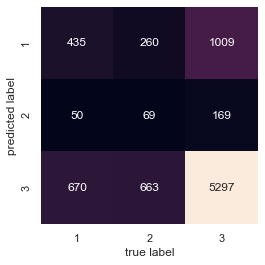

In [18]:
# Ploting confusion matrix with 'seaborn' module
# Use below line only with Jupyter Notebook
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
mat = confusion_matrix(test_labels, predicted)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')
# Save confusion matrix to outputs in Workbench
# plt.savefig(os.path.join('.', 'outputs', 'confusion_matrix.png'))
plt.show()

## Printing classification report

In [19]:
%matplotlib inline
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted,
                            target_names=np.unique(test_labels)))

              precision    recall  f1-score   support

           1       0.26      0.38      0.30      1155
           2       0.24      0.07      0.11       992
           3       0.80      0.82      0.81      6475

    accuracy                           0.67      8622
   macro avg       0.43      0.42      0.41      8622
weighted avg       0.66      0.67      0.66      8622

